In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

In [4]:
# Define the quantization levels
k_values = np.arange(-2, 2.25, 0.25)
num_bins = len(k_values) + 2

# Function to quantize the MFCC coefficients
def quantize_coefficients(coefficients, mean, std):
    bins = np.digitize(coefficients, bins=[mean + k * std for k in k_values])
    bins[coefficients < mean - 2 * std] = 0
    bins[coefficients > mean + 2 * std] = num_bins - 1
    return bins

# Function to compute co-occurrence matrix
def compute_cooccurrence_matrix(bins):
    cooccurrence_matrix = np.zeros((num_bins, num_bins))
    for i in range(len(bins) - 1):
        cooccurrence_matrix[bins[i], bins[i + 1]] += 1
    return cooccurrence_matrix

# Function to compute statistical measures from co-occurrence matrix
def compute_statistical_measures(matrix):
    total = np.sum(matrix)
    prob_matrix = matrix / total
    energy = np.sum(prob_matrix ** 2)
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix + 1e-10))
    homogeneity = np.sum(prob_matrix / (1 + np.abs(np.arange(num_bins)[:, None] - np.arange(num_bins))))
    contrast = np.sum(prob_matrix * (np.arange(num_bins)[:, None] - np.arange(num_bins)) ** 2)
    correlation = np.sum((np.arange(num_bins)[:, None] - np.mean(prob_matrix)) * (np.arange(num_bins) - np.mean(prob_matrix)) * prob_matrix)
    return energy, entropy, homogeneity, contrast, correlation

#### Extracting features from the labeled data

In [8]:
# Define the directory containing the CSV files
base_path = 'LabeledData/'

# Initialize a list to store the features and labels
features = []
labels = []

# Process each CSV file in the directory
for label_folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, label_folder)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                filepath = os.path.join(folder_path, file_name)
                df = pd.read_csv(filepath, header=0)
                
                # Transpose the DataFrame to have MFCC coefficients as columns
                df_transposed = df.T
                
                # Compute the mean and standard deviation for each coefficient
                means = df_transposed.mean(axis=0)
                stds = df_transposed.std(axis=0)
                
                # Initialize a list to store the features for the current file
                file_features = []
                
                # Process each coefficient
                for i in range(df_transposed.shape[1]):
                    coefficients = df_transposed[i]
                    mean = means[i]
                    std = stds[i]
                    
                    # Quantize the coefficients
                    bins = quantize_coefficients(coefficients, mean, std)
                    
                    # Compute the co-occurrence matrix
                    cooccurrence_matrix = compute_cooccurrence_matrix(bins)
                    
                    # Compute the statistical measures
                    energy, entropy, homogeneity, contrast, correlation = compute_statistical_measures(cooccurrence_matrix)
                    
                    # Append the measures to the file features
                    file_features.extend([energy, entropy, homogeneity, contrast, correlation])
                
                # Compute the average of each coefficient over all frames
                avg_coefficients = df_transposed.mean(axis=0).tolist()
                
                # Combine the features
                combined_features = file_features + avg_coefficients
                
                # Append the combined features to the overall features list
                features.append(combined_features)
                
                # Append the label to the labels list
                labels.append(label_folder)

# Convert the features list to a DataFrame
features_df = pd.DataFrame(features)

# Add the labels column to the DataFrame
features_df['label'] = labels

# Display the features DataFrame
print(features_df)

            0         1         2         3          4         5         6  \
0    0.041197  5.246215  0.756234  0.857798  87.441172  0.038027  5.306097   
1    0.022393  5.952968  0.684569  1.466163  87.042359  0.021713  6.100612   
2    0.038930  5.209987  0.786378  0.713919  87.228998  0.039007  5.175563   
3    0.020993  6.122227  0.642724  2.178858  86.355677  0.015064  6.520416   
4    0.060425  4.628222  0.789587  0.604692  84.420080  0.037851  5.301367   
..        ...       ...       ...       ...        ...       ...       ...   
785  0.039627  5.332924  0.796043  0.720849  86.598678  0.029123  5.675693   
786  0.095713  4.008360  0.905102  0.222478  87.490396  0.088268  4.138399   
787  0.069989  4.346523  0.918798  0.173212  87.930736  0.041330  5.071482   
788  0.069251  4.445211  0.898940  0.239199  87.014793  0.048802  4.953755   
789  0.061288  4.670256  0.886883  0.314753  87.702248  0.038020  5.368721   

            7         8          9  ...        111        112  

In [9]:
# Set the desired column as the index
features_df.set_index('label', inplace=True)

In [10]:
# Save DataFrame to CSV, with the index as the label column
features_df.to_csv('LabeledData.csv')

### Extracting features from the unlabeled data

In [11]:
# Define the path to the main directory containing subfolders
main_directory_path = 'TestData/'

# Initialize an empty list to store the data
data_list = []

# Iterate over each subfolder in the main directory
for filename in os.listdir(main_directory_path):
        if filename.endswith('.csv'):
            # Read the CSV file
            file_path = os.path.join(main_directory_path, filename)
            df = pd.read_csv(file_path, header=None)
                       
            # Transpose the DataFrame to have MFCC coefficients as columns
            df_transposed = df.T
            
            # Compute the mean and standard deviation for each coefficient
            means = df_transposed.mean(axis=0)
            stds = df_transposed.std(axis=0)
            
            # Initialize a list to store the features for the current file
            file_features = []
            
            # Process each coefficient
            for i in range(df_transposed.shape[1]):
                coefficients = df_transposed[i]
                mean = means[i]
                std = stds[i]
                
                # Quantize the coefficients
                bins = quantize_coefficients(coefficients, mean, std)
                
                # Compute the co-occurrence matrix
                cooccurrence_matrix = compute_cooccurrence_matrix(bins)
                
                # Compute the statistical measures
                energy, entropy, homogeneity, contrast, correlation = compute_statistical_measures(cooccurrence_matrix)
                
                # Append the measures to the file features
                file_features.extend([energy, entropy, homogeneity, contrast, correlation])
            
            # Compute the average of each coefficient over all frames
            avg_coefficients = df_transposed.mean(axis=0).tolist()
            
            # Combine the features
            combined_features = file_features + avg_coefficients
            
            # Append the combined features to the overall features list
            data_list.append(combined_features)
            

# Convert the list to a DataFrame
data_df = pd.DataFrame(data_list)

# Display the DataFrame
print(data_df)

          0         1         2         3          4         5         6    \
0    0.030387  5.795869  0.696378  1.813626  86.296528  0.023095  6.009681   
1    0.026718  5.783462  0.718850  1.304085  87.595207  0.015774  6.516176   
2    0.036465  5.424046  0.732246  1.072112  85.740403  0.020270  6.131905   
3    0.036962  5.254736  0.745766  0.783597  85.110152  0.044238  4.974656   
4    0.039054  5.248324  0.770309  0.773223  85.558166  0.021983  6.079378   
..        ...       ...       ...       ...        ...       ...       ...   
111  0.065028  4.455411  0.900494  0.232543  86.885727  0.036575  5.333256   
112  0.040021  5.201349  0.752769  0.879492  84.813071  0.024313  5.922859   
113  0.043212  5.187392  0.780848  0.835627  85.003936  0.025487  5.933917   
114  0.031528  5.458152  0.800108  0.577981  88.281553  0.022508  5.948788   
115  0.040512  5.288478  0.763650  0.864980  85.399834  0.039342  5.218234   

          7         8          9    ...        110        111  

In [12]:
# Save DataFrame to CSV
data_df.to_csv('TestData.csv')

In [17]:
features_df = pd.read_csv('LabeledData.csv', index_col='label', header=0)
data_df = pd.read_csv('TestData.csv', header=0, index_col=0)

In [18]:
print(features_df)

                       0         1         2         3          4         5  \
label                                                                         
Lavani          0.041197  5.246215  0.756234  0.857798  87.441172  0.038027   
Lavani          0.022393  5.952968  0.684569  1.466163  87.042359  0.021713   
Lavani          0.038930  5.209987  0.786378  0.713919  87.228998  0.039007   
Lavani          0.020993  6.122227  0.642724  2.178858  86.355677  0.015064   
Lavani          0.060425  4.628222  0.789587  0.604692  84.420080  0.037851   
...                  ...       ...       ...       ...        ...       ...   
NationalAnthem  0.039627  5.332924  0.796043  0.720849  86.598678  0.029123   
NationalAnthem  0.095713  4.008360  0.905102  0.222478  87.490396  0.088268   
NationalAnthem  0.069989  4.346523  0.918798  0.173212  87.930736  0.041330   
NationalAnthem  0.069251  4.445211  0.898940  0.239199  87.014793  0.048802   
NationalAnthem  0.061288  4.670256  0.886883  0.3147

In [19]:
print(data_df)

            0         1         2         3          4         5         6  \
0    0.030387  5.795869  0.696378  1.813626  86.296528  0.023095  6.009681   
1    0.026718  5.783462  0.718850  1.304085  87.595207  0.015774  6.516176   
2    0.036465  5.424046  0.732246  1.072112  85.740403  0.020270  6.131905   
3    0.036962  5.254736  0.745766  0.783597  85.110152  0.044238  4.974656   
4    0.039054  5.248324  0.770309  0.773223  85.558166  0.021983  6.079378   
..        ...       ...       ...       ...        ...       ...       ...   
111  0.065028  4.455411  0.900494  0.232543  86.885727  0.036575  5.333256   
112  0.040021  5.201349  0.752769  0.879492  84.813071  0.024313  5.922859   
113  0.043212  5.187392  0.780848  0.835627  85.003936  0.025487  5.933917   
114  0.031528  5.458152  0.800108  0.577981  88.281553  0.022508  5.948788   
115  0.040512  5.288478  0.763650  0.864980  85.399834  0.039342  5.218234   

            7         8          9  ...        110        111  

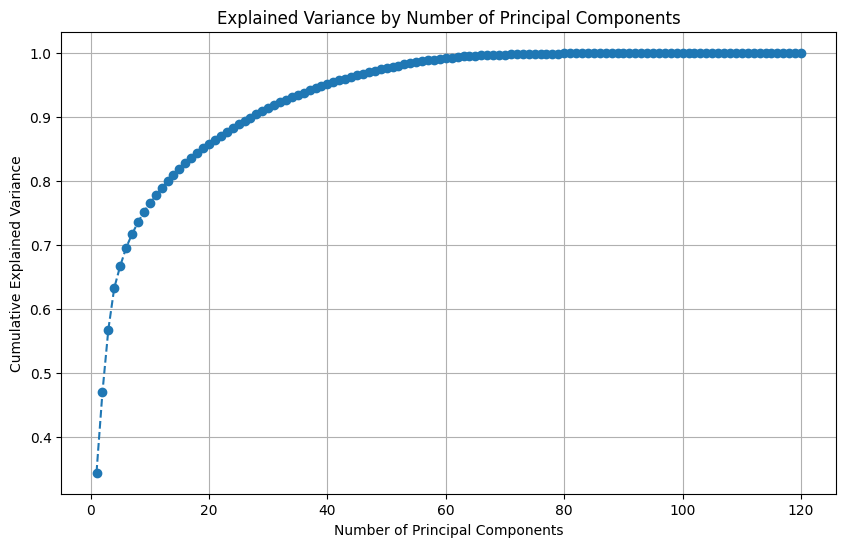

Optimal number of components: 28


In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the features (excluding the label column)
features_standardized = (features_df - features_df.mean()) / features_df.std()

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(features_standardized)

# Create an elbow plot
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Determine the optimal number of components (elbow point)
optimal_components = np.argmax(cumulative_explained_variance >= 0.90) + 1
print(f'Optimal number of components: {optimal_components}')


In [21]:
# Perform PCA with the optimal number of components
pca_optimal = PCA(n_components=optimal_components)
principal_components_optimal = pca_optimal.fit_transform(features_standardized)

# Create a DataFrame with the optimal principal components
pca_df_optimal_labeled = pd.DataFrame(data=principal_components_optimal)

In [23]:
pca_df_optimal_labeled.index = features_df.index
print(pca_df_optimal_labeled)

                       0         1         2         3         4         5   \
label                                                                         
Lavani           0.943442 -0.142437 -3.235505  0.957844 -2.708718  1.858279   
Lavani           6.098106  2.378608  1.056414 -3.257420  0.744735  1.228341   
Lavani          -2.501082 -2.277667 -4.129834  0.983963 -4.988305  1.509493   
Lavani           7.169510  1.725694 -8.102812 -1.988546 -1.636707  0.083667   
Lavani           8.605975  3.748400 -1.403577  1.111849 -3.337493  2.694830   
...                   ...       ...       ...       ...       ...       ...   
NationalAnthem   5.415942  2.891986  5.561367 -2.176129 -0.297785  1.638601   
NationalAnthem  -4.980948 -0.736692  6.102737  0.786248 -1.871881 -0.667959   
NationalAnthem   3.639263  2.425448  6.435965  3.914094 -5.365741  0.417625   
NationalAnthem  -6.780293 -3.234831  3.434311 -0.327645 -2.054737  2.997324   
NationalAnthem -11.898616 -5.540007  1.202624 -2.345

In [26]:
import plotly.express as px
import plotly.graph_objects as go


# Add a 'label' column to pca_df_optimal_labeled for coloring
pca_df_optimal_labeled['label'] = features_df.index

# 2D Scatter plot
fig_2d = px.scatter(pca_df_optimal_labeled, x=pca_df_optimal_labeled.columns[0], y=pca_df_optimal_labeled.columns[1], color='label')
fig_2d.update_layout(title='2D PCA Scatter Plot', xaxis_title='PCA1', yaxis_title='PCA2')
fig_2d.show()

# 3D Scatter plot
fig_3d = px.scatter_3d(pca_df_optimal_labeled, x=pca_df_optimal_labeled.columns[0], y=pca_df_optimal_labeled.columns[1], z=pca_df_optimal_labeled.columns[2], color='label')
fig_3d.update_layout(title='3D PCA Scatter Plot', scene=dict(xaxis_title='PCA1', yaxis_title='PCA2', zaxis_title='PCA3'))
fig_3d.show()

In [29]:
from sklearn.model_selection import train_test_split

# Assuming the target column is named 'label'
X = pca_df_optimal_labeled.drop('label', axis=1)
y = pca_df_optimal_labeled['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Train the models
for name, model in classifiers.items():
    model.fit(X_train, y_train)
    print(f"{name} model trained.")

Logistic Regression model trained.
Decision Tree model trained.
Random Forest model trained.
Support Vector Machine model trained.
K-Nearest Neighbors model trained.


Logistic Regression Training Metrics: Accuracy=0.8496835443037974, Precision=0.8482071689666819, Recall=0.8496835443037974, F1 Score=0.848580051404314
Logistic Regression Testing Metrics: Accuracy=0.7531645569620253, Precision=0.7699754186341435, Recall=0.7531645569620253, F1 Score=0.7530786581717803


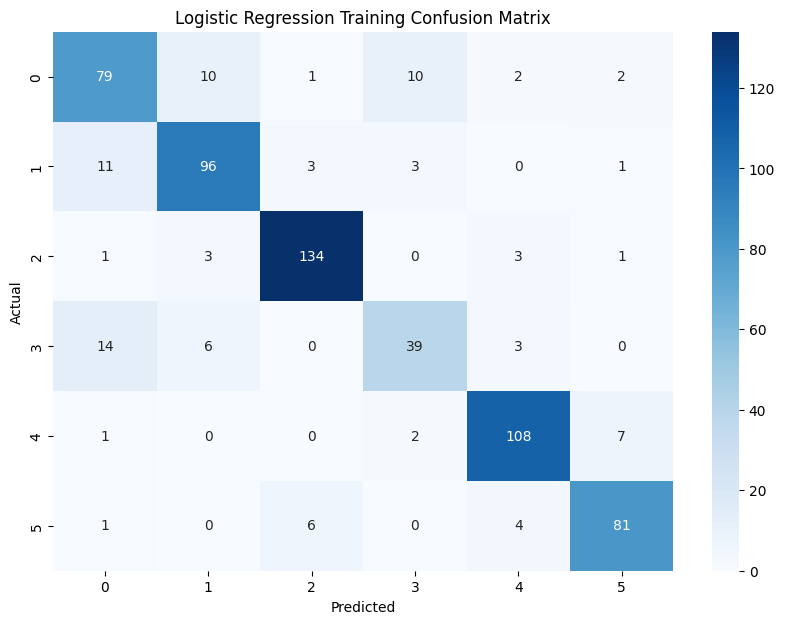

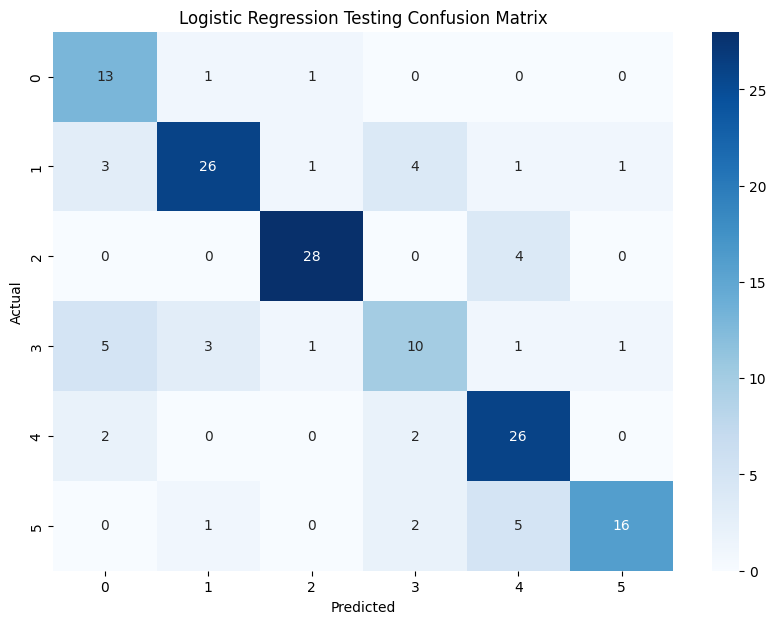

Decision Tree Training Metrics: Accuracy=1.0, Precision=1.0, Recall=1.0, F1 Score=1.0
Decision Tree Testing Metrics: Accuracy=0.6582278481012658, Precision=0.6784640380231824, Recall=0.6582278481012658, F1 Score=0.6613537397017005


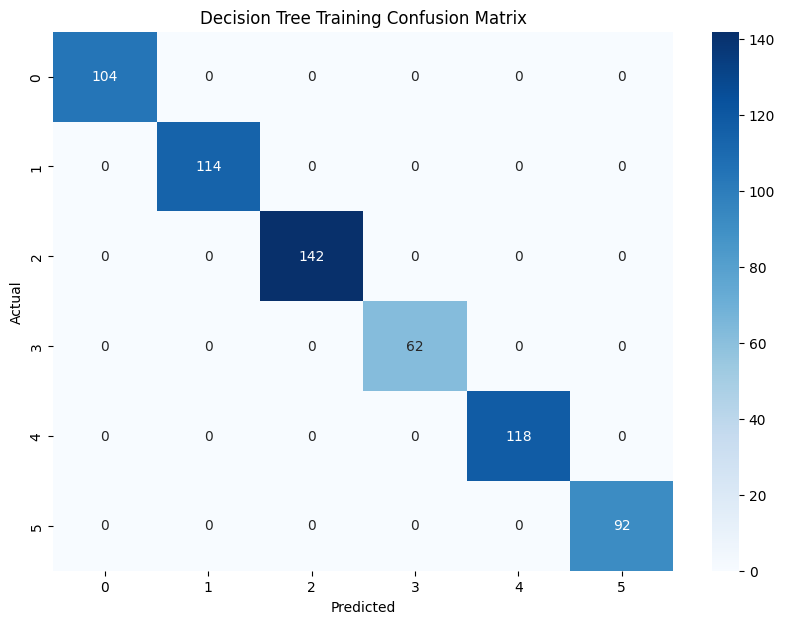

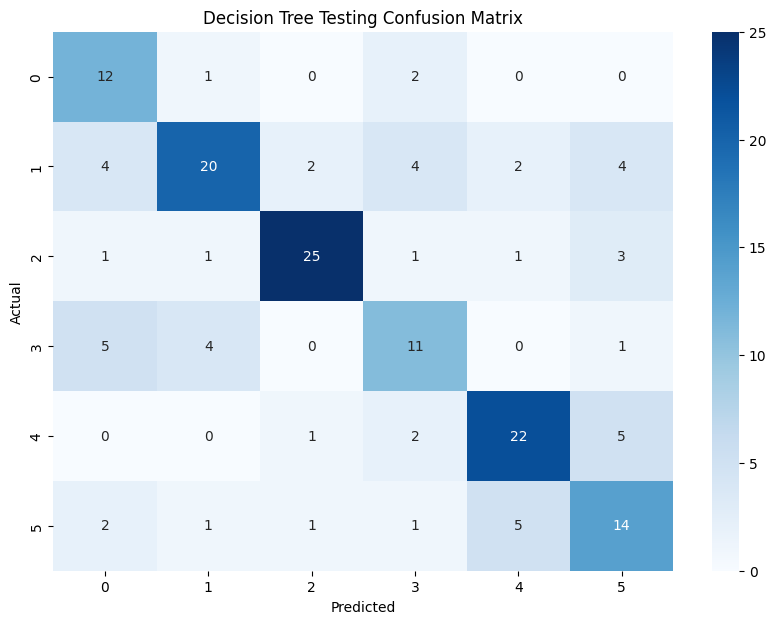

Random Forest Training Metrics: Accuracy=1.0, Precision=1.0, Recall=1.0, F1 Score=1.0
Random Forest Testing Metrics: Accuracy=0.7721518987341772, Precision=0.7887319596223338, Recall=0.7721518987341772, F1 Score=0.7626751056896929


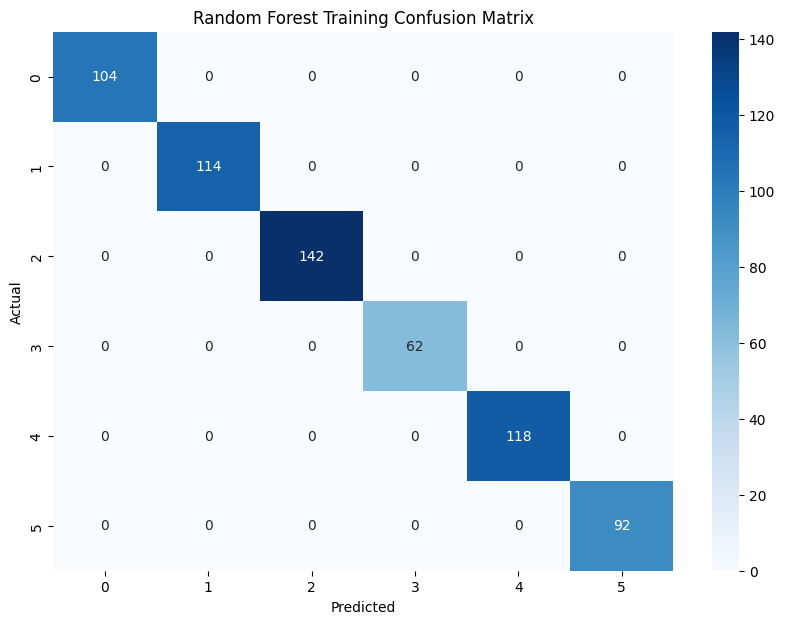

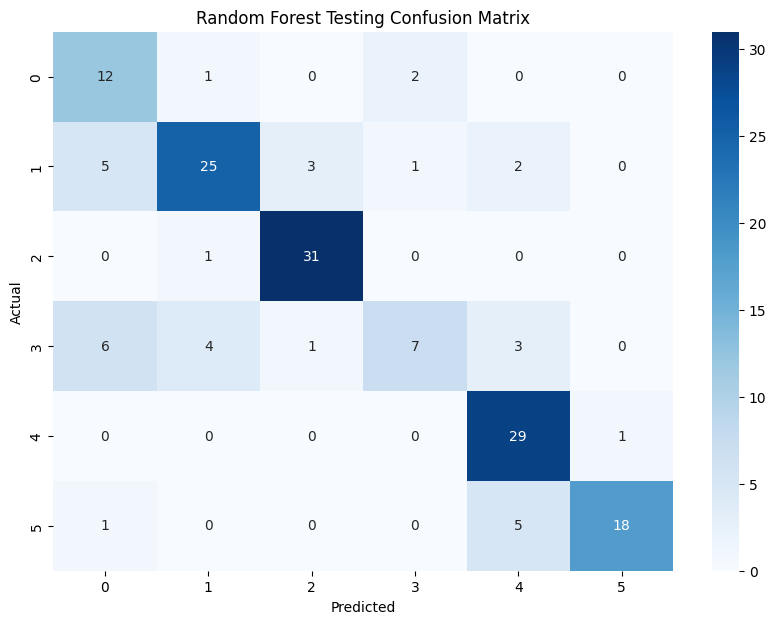

Support Vector Machine Training Metrics: Accuracy=0.8924050632911392, Precision=0.898267433826057, Recall=0.8924050632911392, F1 Score=0.8895364453428822
Support Vector Machine Testing Metrics: Accuracy=0.7911392405063291, Precision=0.8023676856121893, Recall=0.7911392405063291, F1 Score=0.7888112427139266


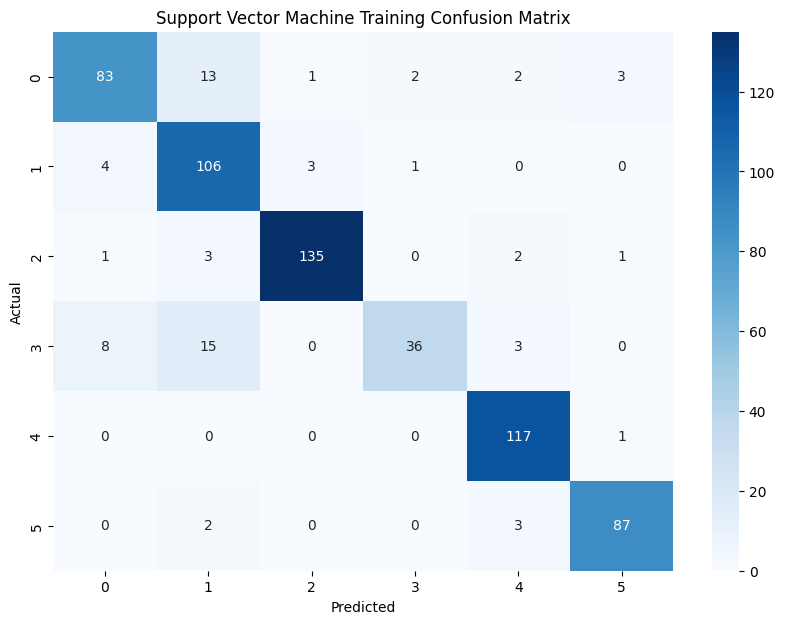

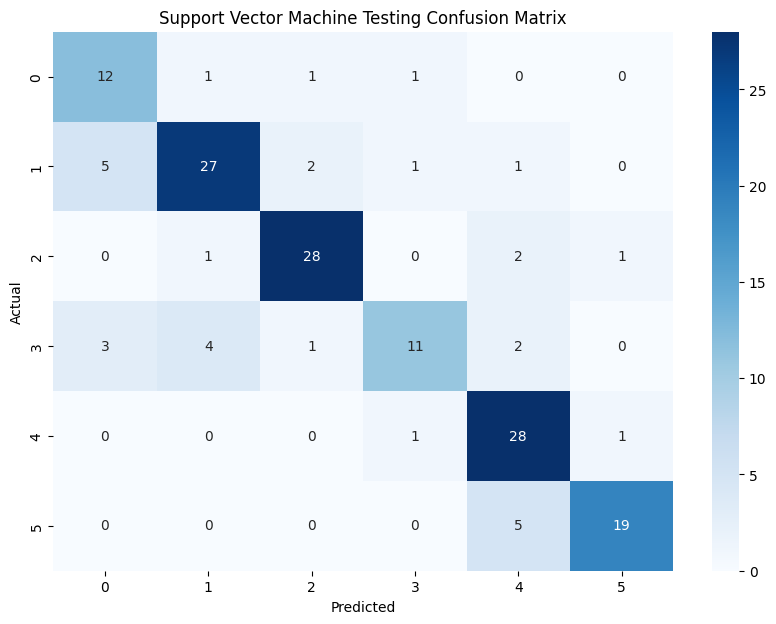

K-Nearest Neighbors Training Metrics: Accuracy=0.7800632911392406, Precision=0.8031978466844514, Recall=0.7800632911392406, F1 Score=0.7730125443652507
K-Nearest Neighbors Testing Metrics: Accuracy=0.6645569620253164, Precision=0.7304386391185668, Recall=0.6645569620253164, F1 Score=0.6525604879373761


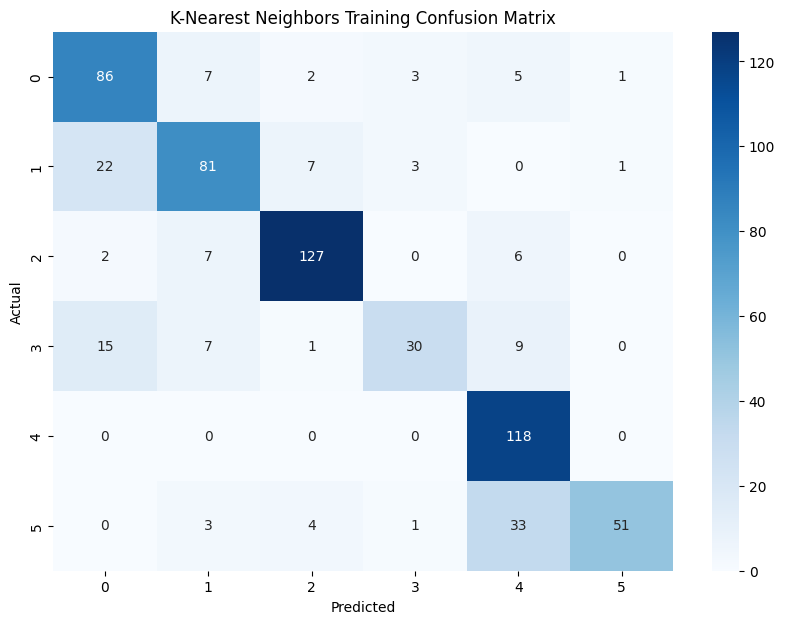

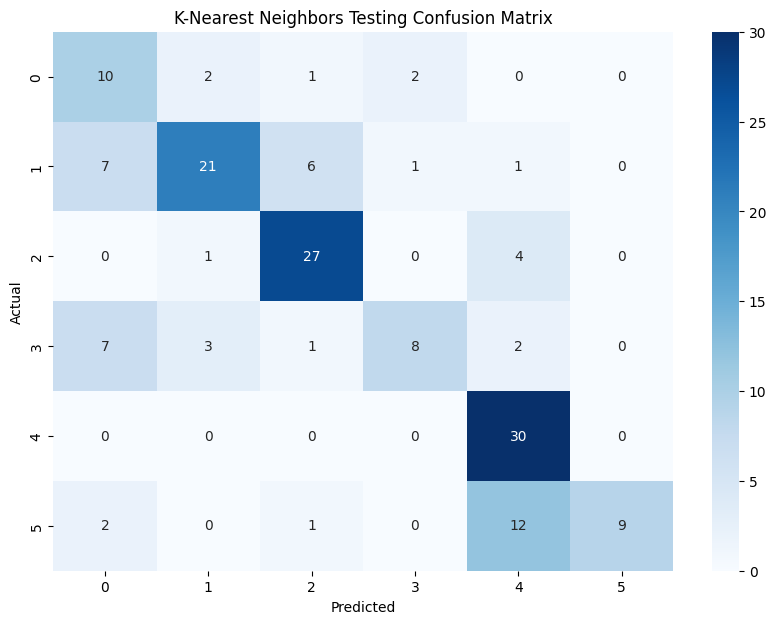

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate the model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y, y_pred)
    return accuracy, precision, recall, f1, conf_matrix

# Evaluate the models on the training set
train_metrics = {name: evaluate_model(model, X_train, y_train) for name, model in classifiers.items()}

# Evaluate the models on the testing set
test_metrics = {name: evaluate_model(model, X_test, y_test) for name, model in classifiers.items()}

# Print the metrics and plot confusion matrices
for name in classifiers.keys():
    print(f"{name} Training Metrics: Accuracy={train_metrics[name][0]}, Precision={train_metrics[name][1]}, Recall={train_metrics[name][2]}, F1 Score={train_metrics[name][3]}")
    print(f"{name} Testing Metrics: Accuracy={test_metrics[name][0]}, Precision={test_metrics[name][1]}, Recall={test_metrics[name][2]}, F1 Score={test_metrics[name][3]}")
    
    # Plot confusion matrix for training set
    plt.figure(figsize=(10, 7))
    sns.heatmap(train_metrics[name][4], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Training Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot confusion matrix for testing set
    plt.figure(figsize=(10, 7))
    sns.heatmap(test_metrics[name][4], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Testing Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

From above it is visible that SVM is giving best results. So procedding with SVM model

SVM Training Metrics: Accuracy=0.8924050632911392, Precision=0.898267433826057, Recall=0.8924050632911392, F1 Score=0.8895364453428822
SVM Testing Metrics: Accuracy=0.7911392405063291, Precision=0.8023676856121893, Recall=0.7911392405063291, F1 Score=0.7888112427139266


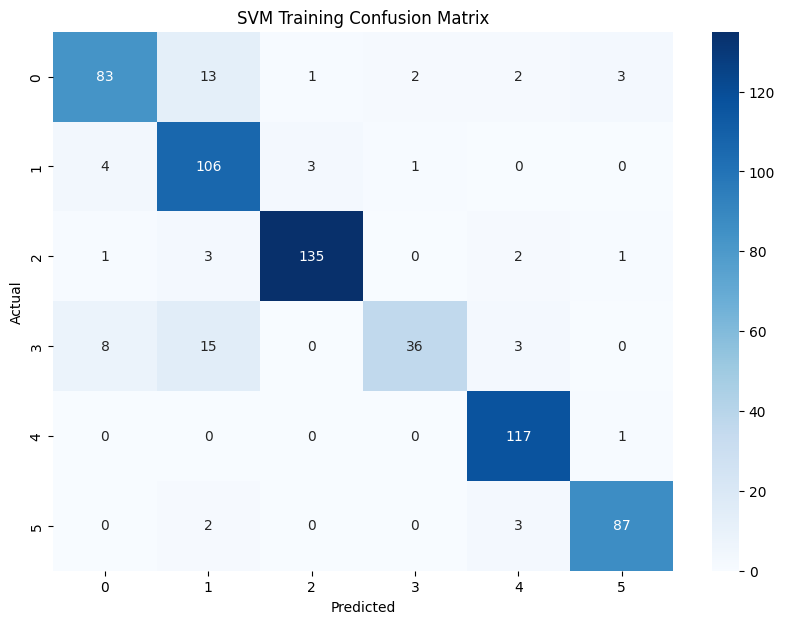

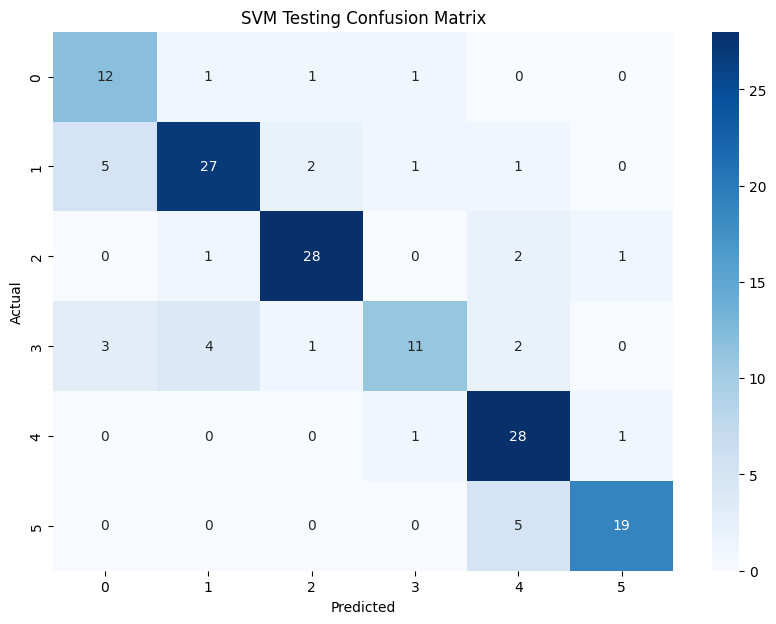

In [40]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the SVM model
svm_model = SVC()

# Train the SVM model
svm_model.fit(X_train, y_train)

# Function to evaluate the model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y, y_pred)
    return accuracy, precision, recall, f1, conf_matrix

# Evaluate the SVM model on the training set
train_metrics = evaluate_model(svm_model, X_train, y_train)

# Evaluate the SVM model on the testing set
test_metrics = evaluate_model(svm_model, X_test, y_test)

# Print the metrics
print(f"SVM Training Metrics: Accuracy={train_metrics[0]}, Precision={train_metrics[1]}, Recall={train_metrics[2]}, F1 Score={train_metrics[3]}")
print(f"SVM Testing Metrics: Accuracy={test_metrics[0]}, Precision={test_metrics[1]}, Recall={test_metrics[2]}, F1 Score={test_metrics[3]}")

# Plot confusion matrix for training set
plt.figure(figsize=(10, 7))
sns.heatmap(train_metrics[4], annot=True, fmt='d', cmap='Blues')
plt.title('SVM Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot confusion matrix for testing set
plt.figure(figsize=(10, 7))
sns.heatmap(test_metrics[4], annot=True, fmt='d', cmap='Blues')
plt.title('SVM Testing Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Prediction on the unlabeled data

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the features 
test_features_standardized = (data_df - data_df.mean()) / data_df.std()

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(test_features_standardized)


In [45]:
#optimal number of components from training data
optimal_components = 28

# Perform PCA with the optimal number of components
pca_optimal = PCA(n_components=optimal_components)
principal_components_optimal = pca_optimal.fit_transform(test_features_standardized)

# Create a DataFrame with the optimal principal components
pca_df_optimal_unlabeled = pd.DataFrame(data=principal_components_optimal)

In [46]:
print(pca_df_optimal_unlabeled)

           0         1         2         3         4         5         6   \
0    1.583136  3.742376 -1.406306 -0.965336  1.692501 -0.628264  1.934912   
1    7.684954  2.830343  1.139662  0.488741 -0.121536  0.250052  1.593665   
2   -1.698946  7.089917 -0.846227  0.381829  0.356498  0.795038  0.570979   
3   -3.863518  5.934021  5.786588  1.109857  1.432975 -0.825058 -2.151544   
4   -3.499106  1.747188 -1.337211  0.444653  0.926369  2.021732  1.208181   
..        ...       ...       ...       ...       ...       ...       ...   
111 -7.172992 -4.770277 -2.118115 -4.325524 -0.287083 -1.864648 -1.939023   
112  0.951232  2.125388 -0.180446 -0.419413 -0.591865  0.191688  0.518281   
113 -3.076726  4.396585 -1.380449 -1.536100 -0.779221 -0.433773  3.055005   
114 -0.932747 -2.189276  3.899899 -0.623509  0.492922  3.217223  1.695973   
115 -1.810995  0.466068  1.952063 -2.254097 -2.072505 -2.922973  1.123995   

           7         8         9   ...        18        19        20  \
0  

In [47]:
X_unlabeled = pca_df_optimal_unlabeled

# Predict the labels for the unlabeled data
y_pred_unlabeled = svm_model.predict(X_unlabeled)

#Set the index of the DataFrame as the predicted labels
pca_df_optimal_unlabeled.index = y_pred_unlabeled

# Add the predicted labels to the DataFrame
pca_df_optimal_unlabeled['label'] = y_pred_unlabeled

# Display the DataFrame with predicted labels
print(pca_df_optimal_unlabeled)

                       0         1         2         3         4         5  \
Lavani          1.583136  3.742376 -1.406306 -0.965336  1.692501 -0.628264   
MichaelJackson  7.684954  2.830343  1.139662  0.488741 -0.121536  0.250052   
KishoreKumar   -1.698946  7.089917 -0.846227  0.381829  0.356498  0.795038   
NationalAnthem -3.863518  5.934021  5.786588  1.109857  1.432975 -0.825058   
BhavGeet       -3.499106  1.747188 -1.337211  0.444653  0.926369  2.021732   
...                  ...       ...       ...       ...       ...       ...   
AshaBhosle     -7.172992 -4.770277 -2.118115 -4.325524 -0.287083 -1.864648   
MichaelJackson  0.951232  2.125388 -0.180446 -0.419413 -0.591865  0.191688   
AshaBhosle     -3.076726  4.396585 -1.380449 -1.536100 -0.779221 -0.433773   
NationalAnthem -0.932747 -2.189276  3.899899 -0.623509  0.492922  3.217223   
MichaelJackson -1.810995  0.466068  1.952063 -2.254097 -2.072505 -2.922973   

                       6         7         8         9  ...    

In [48]:
#Visualize the predicted labels using a 2D scatter plot
fig_2d = px.scatter(pca_df_optimal_unlabeled, x=pca_df_optimal_unlabeled.columns[0], y=pca_df_optimal_unlabeled.columns[1], color='label')
fig_2d.update_layout(title='2D PCA Scatter Plot', xaxis_title='PCA1', yaxis_title='PCA2')
fig_2d.show()

#Visualize the predicted labels using a 3D scatter plot
fig_3d = px.scatter_3d(pca_df_optimal_unlabeled, x=pca_df_optimal_unlabeled.columns[0], y=pca_df_optimal_unlabeled.columns[1], z=pca_df_optimal_unlabeled.columns[2], color='label')
fig_3d.update_layout(title='3D PCA Scatter Plot', scene=dict(xaxis_title='PCA1', yaxis_title='PCA2', zaxis_title='PCA3'))
fig_3d.show()

In [49]:
# Remove the label column from the DataFrame
pca_df_optimal_unlabeled.drop('label', axis=1, inplace=True)

# Save the predicted labels to a CSV file
pca_df_optimal_unlabeled.to_csv('PredictedLabels.csv')